In [1]:
#######################################
# COMS30014 - Artificial Intelligence #
# Multiagent Systems Lab - I          #
# Covid-19 Simulation                 #
#######################################

# Before starting, make sure you have installed Mesa 
# You could install via command line --- pip install mesa
# For generating plots, you will need matplotlib which too you can install via command line --- pip install matplotlib

In [2]:
NUM_OF_AGENTS = 1000

# PLACES
PARK = 0
HOME = 1
GROCERY = 2
QC = 3 # Quarantine center

# INFECTION STATES
NOT_INFECTED = 0
INFECTED_A = 1
INFECTED_S = 2
CRITICAL = 3
CURED = 4
DECEASED = 5

# Capacity of quarantine center
QC_LIMIT = 0 # Capacity of quarantine center

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class HumanAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.homeId = unique_id//4
        self.health = NOT_INFECTED

    def step(self):
        self.updateHealth()
        self.move()

    # Function for mobility pattern modeling
    
    def move(self):
        x, y = self.pos
        if x==QC:
            return
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == CRITICAL:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        if self.model.quarantine and self.model.QC_Occupancy < QC_LIMIT and self.health == INFECTED_S and self.random.uniform(0, 1) <= 0.20:
            self.model.grid.move_agent(self, (QC,0))
            self.model.QC_Occupancy += 1
            return
        if x == HOME:
          p = self.random.uniform(0, 1)
          # Visit park with 10% probability
          if p <= 0.1:
            newX = PARK
            newY = self.random.choice((0,1)) # Visit one of the two parks
          # Visit grocery store with 20% probability
          elif p <= 0.3:
            newX = GROCERY
            newY = self.random.choice((0,1,2,3,4)) # Visit one of the five grocery stores
          else:
            newX = x
            newY = y
        if x == GROCERY or x == PARK: # If grocery or park, return home
          newX = HOME
          newY = self.homeId
        self.model.grid.move_agent(self, (newX,newY))

    # Function for modeling the spread of the virus

    def updateHealth(self):
        p = self.random.uniform(0, 1)
        if self.health == INFECTED_A and p > 0.75:
                self.health += 1
        elif self.health == INFECTED_S:
            if p > 0.75 and p <= 0.85:
                self.health += 1
            elif p > 0.85:
                self.health = CURED
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1                
        elif self.health == CRITICAL:
            if p > 0.75 and p <= 0.95:
                self.health += 1
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1
            elif p > 0.95:
                self.health = DECEASED
                self.model.deceasedCount += 1
                x,y = self.pos
                if x == QC:
                    self.model.QC_Occupancy -= 1
        return
    
    def infect(self):
        p = self.random.uniform(0, 1)
        if self.health == NOT_INFECTED and p > self.model.p0b:
                self.health += 1


def compute_infected(model):
    infectedAgents = [agent for agent in model.schedule.agents if agent.health in (INFECTED_A, INFECTED_S, CRITICAL) ]
    return len(infectedAgents)

class CovidModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, startingState, quarantine = False, socialDistancing = False):
        self.num_agents = N
        # self.random.seed(42)
        self.QC_Occupancy = 0
        self.deceasedCount = 0
        self.quarantine = quarantine
        self.grid = MultiGrid(4 if quarantine else 3, 250, False)
        self.schedule = RandomActivation(self)
        self.running = True
        
        # With socialdistancing the probability of infection is 10% (p0b = 0.9) otherwise it is 50%
        self.p0b = 0.5
        
        ###########
        # HINT: 
        # You need to update the the next if block to correctly set infection probability when social distancing is TRUE
        # You need to change quarantine center capacity too
        ###########
        if socialDistancing:
          self.p0b = 0.9
        ###########
        
        # Create agents
        for i in range(self.num_agents):
            a = HumanAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (HOME, a.homeId))
        for a in self.random.sample(self.schedule.agents,int(startingState*N)):
            a.health = INFECTED_A
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_infected,
                             "QC_Occupancy": "QC_Occupancy"}
            )
    def step(self):
        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        self.identifyAgentsAndUpdateSpread()
    def identifyAgentsAndUpdateSpread(self):
        # Park
        for y in range(2):
            agents = self.grid.get_cell_list_contents([(PARK,y)])
            self.updateSpread(agents)
        # Grocery
        for y in range(5):
            agents = self.grid.get_cell_list_contents([(GROCERY,y)])
            self.updateSpread(agents)
        # Home
        for y in range(250):
            agents = self.grid.get_cell_list_contents([(HOME,y)])
            self.updateSpread(agents)
    def updateSpread(self, agents):
        if any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in agents):
            [a.infect() for a in agents]

In [4]:

def runSimulation(startingState,quarantine=False,socialDistancing=False):
    modelInst = CovidModel(NUM_OF_AGENTS, startingState, quarantine, socialDistancing)
    i=0
    while any(a.health in (INFECTED_A, INFECTED_S, CRITICAL) for a in modelInst.schedule.agents):
        i += 1
        modelInst.step()
    modelDF = modelInst.datacollector.get_model_vars_dataframe()
    
    return i, modelInst.deceasedCount, modelDF.QC_Occupancy,modelDF.Infected

# Baseline 1
StartingState = 10%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 47.2
Average of the Day with peak Infection (775.2): 5.3
Average Number of Casualties: 76.0


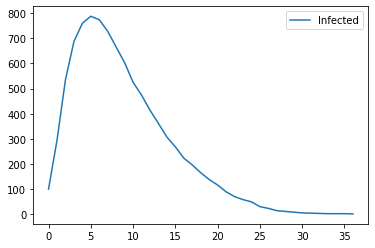

In [5]:
StartingState = 10
quarantine=False
socialDistancing=False
QC_LIMIT = 0

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState/100,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))


# Baseline 2
StartingState = 25%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 43.7
Average of the Day with peak Infection (800.9): 4.3
Average Number of Casualties: 81.7


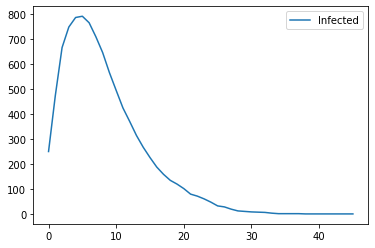

In [6]:
StartingState = 25
quarantine=False
socialDistancing=False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0
for i in range(10):
    days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState/100,quarantine,socialDistancing)
    averageDays+=days
    dayWithMaxInfectionRate+=Infected.idxmax()
    maxInfection += Infected.max()
    averageCasualties += Casualties
    if i == 9:
        # QC_Occupancy.plot(legend=True)
        Infected.plot(legend=True)
print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))


# Baseline 3
StartingState = 50%

Quarantine=False

Social Distancing=False

Average number of days before stabilization: 40.9
Average of the Day with peak Infection (853.7): 3.0
Average Number of Casualties: 80.5


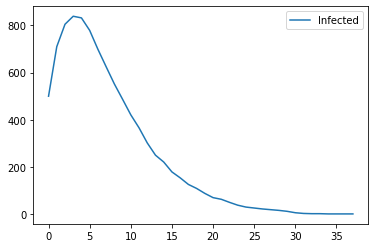

In [7]:
# Add code for baseline 3 here
StartingState = 50
quarantine = False
socialDistancing = False

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(0, 10):
  days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState/100, quarantine, socialDistancing)
  averageDays += days
  dayWithMaxInfectionRate+= Infected.idxmax()
  maxInfection += Infected.max()
  averageCasualties += Casualties
  if i == 9:
    Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Simulation report 1

- Q) When the does simulation stabilise?
  - A) 43.3 days
- Q) When was the infection at its peak?
  - A) 5.3 days
- Q) How many people die by the time the simulation stabilises
  - A) 77.6 days

# Simulation report 2

- Q) When the does simulation stabilise?
  - A) 44.7 days
- Q) When was the infection at its peak?
  - A) 4.3 days
- Q) How many people die by the time the simulation stabilises
  - A) 79.9 days

# Simulation report 3

- Q) When the does simulation stabilise?
  - A) 41.3 days
- Q) When was the infection at its peak?
  - A) 3.0 days
- Q) How many people die by the time the simulation stabilises
  - A) 77.9 days

# Adding Quarantine Centers
Enable quarantine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

Average number of days before stabilization: 42.8
Average of the Day with peak Infection (770.0): 5.8
Average Number of Casualties: 78.4


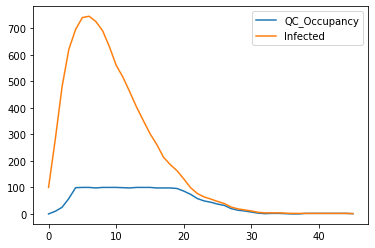

In [8]:
# Add code to generate plots with quarantine centers here
# Add code for baseline 3 here
StartingState = 10
quarantine = True
socialDistancing = False
QC_LIMIT = 100

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(0, 10):
  days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState/100, quarantine, socialDistancing)
  averageDays += days
  dayWithMaxInfectionRate+= Infected.idxmax()
  maxInfection += Infected.max()
  averageCasualties += Casualties
  if i == 9:
    QC_Occupancy.plot(legend=True)
    Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Enabling Social Distancing Norms
Enable social distancing norms in addition to quaratine centers for each baseline and see how the plots change
In the line plot, include a plot for capacity of qurantine center too

Average number of days before stabilization: 96.3
Average of the Day with peak Infection (274.0): 10.1
Average Number of Casualties: 66.5


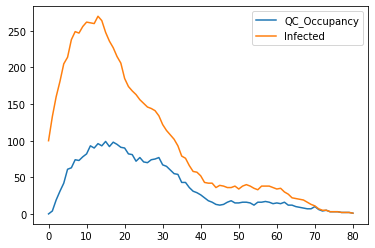

In [9]:
# Add code to generate plots with social distancing and quarantine centers here
# Add code to generate plots with quarantine centers here
# Add code for baseline 3 here
StartingState = 10
quarantine = True
socialDistancing = True
QC_LIMIT = 100

averageDays = 0
dayWithMaxInfectionRate = 0
maxInfection = 0
averageCasualties = 0

for i in range(0, 10):
  days, Casualties, QC_Occupancy, Infected = runSimulation(StartingState/100, quarantine, socialDistancing)
  averageDays += days
  dayWithMaxInfectionRate+= Infected.idxmax()
  maxInfection += Infected.max()
  averageCasualties += Casualties
  if i == 9:
    QC_Occupancy.plot(legend=True)
    Infected.plot(legend=True)

print('Average number of days before stabilization: ' + str(averageDays/10))
print('Average of the Day with peak Infection ('+str(maxInfection/10)+'): ' + str(dayWithMaxInfectionRate/10))
print('Average Number of Casualties: ' + str(averageCasualties/10))

# Observations

- The number of casualties has decreased 
- Stabilisation takes longer
- Peak is reached later

In [ ]:
class HumanAgent2(HumanAgent):
  def __init__(*args):
    super.__init__(*args)
  
class CovidModel2(CovidModel):
  def __init__(*args):
    super.__init__(*args)